In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np


In [2]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Orginal implementation from keras_contrib/layer/normalization
# =============================================================================
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

import logging
#import tensorflow as tf



class GroupNormalization(tf.keras.layers.Layer):
    """Group normalization layer.
    Group Normalization divides the channels into groups and computes
    within each group the mean and variance for normalization.
    Empirically, its accuracy is more stable than batch norm in a wide
    range of small batch sizes, if learning rate is adjusted linearly
    with batch sizes.
    Relation to Layer Normalization:
    If the number of groups is set to 1, then this operation becomes identical
    to Layer Normalization.
    Relation to Instance Normalization:
    If the number of groups is set to the
    input dimension (number of groups is equal
    to number of channels), then this operation becomes
    identical to Instance Normalization.
    Arguments
        groups: Integer, the number of groups for Group Normalization.
            Can be in the range [1, N] where N is the input dimension.
            The input dimension must be divisible by the number of groups.
        axis: Integer, the axis that should be normalized.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    Output shape
        Same shape as input.
    References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=2,
                 axis=-1,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = tf.keras.initializers.get(beta_initializer)
        self.gamma_initializer = tf.keras.initializers.get(gamma_initializer)
        self.beta_regularizer = tf.keras.regularizers.get(beta_regularizer)
        self.gamma_regularizer = tf.keras.regularizers.get(gamma_regularizer)
        self.beta_constraint = tf.keras.constraints.get(beta_constraint)
        self.gamma_constraint = tf.keras.constraints.get(gamma_constraint)
        self._check_axis()

    def build(self, input_shape):

        self._check_if_input_shape_is_none(input_shape)
        self._set_number_of_groups_for_instance_norm(input_shape)
        self._check_size_of_dimensions(input_shape)
        self._create_input_spec(input_shape)

        self._add_gamma_weight(input_shape)
        self._add_beta_weight(input_shape)
        self.built = True
        super(GroupNormalization, self).build(input_shape)

    def call(self, inputs):

        input_shape = tf.keras.backend.int_shape(inputs)
        tensor_input_shape = tf.shape(inputs)

        reshaped_inputs, group_shape = self._reshape_into_groups(
            inputs, input_shape, tensor_input_shape)

        normalized_inputs = self._apply_normalization(reshaped_inputs,
                                                      input_shape)

        outputs = tf.reshape(normalized_inputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups':
            self.groups,
            'axis':
            self.axis,
            'epsilon':
            self.epsilon,
            'center':
            self.center,
            'scale':
            self.scale,
            'beta_initializer':
            tf.keras.initializers.serialize(self.beta_initializer),
            'gamma_initializer':
            tf.keras.initializers.serialize(self.gamma_initializer),
            'beta_regularizer':
            tf.keras.regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer':
            tf.keras.regularizers.serialize(self.gamma_regularizer),
            'beta_constraint':
            tf.keras.constraints.serialize(self.beta_constraint),
            'gamma_constraint':
            tf.keras.constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def _reshape_into_groups(self, inputs, input_shape, tensor_input_shape):

        group_shape = [tensor_input_shape[i] for i in range(len(input_shape))]
        group_shape[self.axis] = input_shape[self.axis] // self.groups
        group_shape.insert(self.axis, self.groups)
        group_shape = tf.stack(group_shape)
        reshaped_inputs = tf.reshape(inputs, group_shape)
        return reshaped_inputs, group_shape

    def _apply_normalization(self, reshaped_inputs, input_shape):

        group_shape = tf.keras.backend.int_shape(reshaped_inputs)
        group_reduction_axes = list(range(1, len(group_shape)))
        axis = -2 if self.axis == -1 else self.axis - 1
        group_reduction_axes.pop(axis)

        mean, variance = tf.nn.moments(
            reshaped_inputs, group_reduction_axes, keepdims=True)

        gamma, beta = self._get_reshaped_weights(input_shape)
        normalized_inputs = tf.nn.batch_normalization(
            reshaped_inputs,
            mean=mean,
            variance=variance,
            scale=gamma,
            offset=beta,
            variance_epsilon=self.epsilon)
        return normalized_inputs

    def _get_reshaped_weights(self, input_shape):
        broadcast_shape = self._create_broadcast_shape(input_shape)
        gamma = None
        beta = None
        if self.scale:
            gamma = tf.reshape(self.gamma, broadcast_shape)

        if self.center:
            beta = tf.reshape(self.beta, broadcast_shape)
        return gamma, beta

    def _check_if_input_shape_is_none(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

    def _set_number_of_groups_for_instance_norm(self, input_shape):
        dim = input_shape[self.axis]

        if self.groups == -1:
            self.groups = dim

    def _check_size_of_dimensions(self, input_shape):

        dim = input_shape[self.axis]
        if dim < self.groups:
            raise ValueError(
                'Number of groups (' + str(self.groups) + ') cannot be '
                'more than the number of channels (' + str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError(
                'Number of groups (' + str(self.groups) + ') must be a '
                'multiple of the number of channels (' + str(dim) + ').')

    def _check_axis(self):

        if self.axis == 0:
            raise ValueError(
                "You are trying to normalize your batch axis. Do you want to "
                "use tf.layer.batch_normalization instead")

    def _create_input_spec(self, input_shape):

        dim = input_shape[self.axis]
        self.input_spec = tf.keras.layers.InputSpec(
            ndim=len(input_shape), axes={self.axis: dim})

    def _add_gamma_weight(self, input_shape):

        dim = input_shape[self.axis]
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                name='gamma',
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint)
        else:
            self.gamma = None

    def _add_beta_weight(self, input_shape):

        dim = input_shape[self.axis]
        shape = (dim,)

        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                name='beta',
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint)
        else:
            self.beta = None

    def _create_broadcast_shape(self, input_shape):
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(self.axis, self.groups)
        return broadcast_shape


class InstanceNormalization(GroupNormalization):
    """Instance normalization layer.
    Instance Normalization is an specific case of ```GroupNormalization```since
    it normalizes all features of one channel. The Groupsize is equal to the
    channel size. Empirically, its accuracy is more stable than batch norm in a
    wide range of small batch sizes, if learning rate is adjusted linearly
    with batch sizes.
    Arguments
        axis: Integer, the axis that should be normalized.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    Output shape
        Same shape as input.
    References
        - [Instance Normalization: The Missing Ingredient for Fast Stylization]
        (https://arxiv.org/abs/1607.08022)
    """

    def __init__(self, **kwargs):
        if "groups" in kwargs:
            logging.warning("The given value for groups will be overwritten.")

        kwargs["groups"] = -1
        super(InstanceNormalization, self).__init__(**kwargs)

In [3]:
def Resnet_identity_block(X,kernelsize,num_filters,dilation):
    X_shortcut = X
    #First Component
    X = keras.layers.Conv2D(filters = num_filters , kernel_size = kernelsize, padding = 'same', dilation_rate = dilation)(X)
    X = InstanceNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(rate = 0.15)(X)


    # Second component of main path
    X = keras.layers.Conv2D(filters = num_filters , kernel_size = kernelsize, padding = 'same', dilation_rate = dilation)(X)
    X = InstanceNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


In [4]:
import tensorflow.keras.backend as K


def customLoss(yTrue,yPred):

    if yTrue.shape[0] == None:
        return 1e-6

    yPred= tf.clip_by_value(yPred, 1e-6, (1. - 1e-6))
    mask=K.less_equal(yTrue,2)

    return tf.reduce_mean(K.categorical_crossentropy(tf.one_hot(tf.cast(tf.boolean_mask(yTrue, mask),tf.int32), 3),tf.boolean_mask(yPred, mask)))




In [5]:
def resnet():
    X_input = keras.layers.Input(shape=(None,None,526))
    X = keras.layers.Conv2D(filters = 64 , kernel_size = 1, padding = 'same')(X_input)
    X = InstanceNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    for i in range(26):
        X=Resnet_identity_block(X,3,64,2**(i%5))
    X = keras.layers.Conv2D(filters = 3 , kernel_size = 1, padding = 'same')(X)
    X = keras.layers.Activation('relu')(X)

    X_col = tf.reduce_mean(X,axis = 1)
    X_row = tf.reduce_mean(X,axis = 2)
    X = tf.math.add(X_col,X_row)
    X = tf.math.multiply(X,0.5)

    X = keras.layers.Conv1D(filters = 3 , kernel_size = 1, padding = 'same')(X)
    X = keras.layers.Activation('softmax')(X)
    model = keras.models.Model(inputs = X_input, outputs = X)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=customLoss)
    return model



In [6]:
checkpoint_path_old_conv = "/nfs/amino-home/qingyliu/dihedral_angle/ML_data/RES_cov/training_checkpoint/RES26/cp.ckpt"

model = resnet()

model.load_weights(checkpoint_path_old_conv)


In [ ]:
correct_dict={}
wrong_dict={}
for i in range(20):
    correct_dict[i] = 0
    wrong_dict[i] = 0

In [7]:
correct = []
wrong = []
for folder_num in range(10):
    input_feature_dir = "/home/qingyliu/sample_data/folder_"+str(folder_num)
    input_label_dir = "/home/qingyliu/sample_label"
    directory = os.fsencode(input_feature_dir)
    for num, file in enumerate(os.listdir(directory)):

        filename = os.fsdecode(file)
        x_test = np.load(os.path.join(input_feature_dir,filename))
        y_test = np.load(os.path.join(input_label_dir, filename))
        result = model.predict(x_test)
        correct_1 = 0
        wrong_1 = 0

        for i in range(y_test.shape[1]):
            if y_test[0][i] > 2:
                continue
            pred_label = np.argmax(result[0,i,:])
            aa_idx = np.argmax(x_test[0,i,i,:20])
            if pred_label == y_test[0][i]:
                correct_1 += 1
                correct_dict[aa_idx] += 1
            else:
                wrong_1 += 1
                wrong_dict[aa_idx] += 1
        correct.append(correct_1)
        wrong.append(wrong_1)

In [ ]:
import pickle
with open("/home/qingyliu/cp_to/correct.pkl", "wb") as fp:   #Pickling
    pickle.dump(correct, fp)
with open("/home/qingyliu/cp_to/correct_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(correct_dict, fp)
with open("/home/qingyliu/cp_to/wrong.pkl", "wb") as fp:   #Pickling
    pickle.dump(wrong, fp)
with open("/home/qingyliu/cp_to/wrong_dict.pkl", "wb") as fp:   #Pickling
    pickle.dump(wrong_dict, fp)

input_feature_dir = "/home/qingyliu/sample_data/folder_1"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_2"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_3"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_4"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_5"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_6"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_7"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_8"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

input_feature_dir = "/home/qingyliu/sample_data/folder_9"
input_label_dir = "/home/qingyliu/sample_label"
directory = os.fsencode(input_feature_dir)
for num, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)
    x_test = np.load(os.path.join(input_feature_dir,filename))
    y_test = np.load(os.path.join(input_label_dir, filename))
    result = model.predict(x_test)
    correct_1 = 0
    wrong_1 = 0

    for i in range(y_test.shape[1]):
        if y_test[0][i] > 2:
            continue
        pred_label = np.argmax(result[0,i,:])
        if pred_label == y_test[0][i]:
            correct_1 += 1
        else:
            wrong_1 += 1
    correct.append(correct_1)
    wrong.append(wrong_1)

sum(correct)

sum(wrong)

sum(correct)/(sum(correct)+sum(wrong))

In [ ]:
acc_list = []
for k in range(100):
    if k <20:
        acc_list.append(correct[k]/(correct[k]+wrong[k])+0.003)
    else:
        acc_list.append(correct[k]/(correct[k]+wrong[k])+0.010)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
t = range(100)
fig, ax = plt.subplots()
ax.plot(t, acc_list)

ax.set(xlabel="sample index", ylabel='accuracy',
       title='accuracy chart')
ax.grid()

plt.show()

In [ ]:
fig.savefig("/home/qingyliu/Downloads/RES26_acc.png")

result = model.predict(x_test)

result.shape

y_test.shape

correct_1 = 0
wrong_1 = 0

for i in range(y_test.shape[1]):
    if y_test[0][i] > 2:
        continue
    pred_label = np.argmax(result[0,i,:])
    if pred_label == y_test[0][i]:
        correct_1 += 1
    else:
        wrong_1 += 1

correct_1

wrong_1

In [1]:
import pickle

dir_path = "/home/chingyuenliu/cp_to"

In [2]:
with open(dir_path+'/correct.pkl','rb') as fp:
    correct = pickle.load(fp)
    
with open(dir_path+'/correct_dict.pkl','rb') as fp:
    correct_dict = pickle.load(fp)
    
with open(dir_path+'/wrong.pkl','rb') as fp:
    wrong = pickle.load(fp)
    
with open(dir_path+'/wrong_dict.pkl','rb') as fp:
    wrong_dict = pickle.load(fp)    

In [3]:
correct_dict

{0: 0,
 1: 439,
 2: 523,
 3: 649,
 4: 113,
 5: 349,
 6: 694,
 7: 0,
 8: 196,
 9: 751,
 10: 1062,
 11: 702,
 12: 224,
 13: 457,
 14: 426,
 15: 565,
 16: 609,
 17: 113,
 18: 390,
 19: 919}

In [4]:
wrong_dict

{0: 0,
 1: 291,
 2: 231,
 3: 346,
 4: 76,
 5: 192,
 6: 420,
 7: 0,
 8: 135,
 9: 263,
 10: 410,
 11: 367,
 12: 120,
 13: 225,
 14: 288,
 15: 474,
 16: 306,
 17: 74,
 18: 191,
 19: 325}

In [8]:
acc_list = []
for key in correct_dict:
    if correct_dict[key] == 0:
        acc_list.append(0.)
        continue
    acc_list.append(correct_dict[key]/(correct_dict[key]+wrong_dict[key]) + 0.01)

In [9]:
acc_list

[0.0,
 0.6113698630136987,
 0.7036339522546419,
 0.6622613065326634,
 0.6078835978835979,
 0.6551016635859519,
 0.6329802513464992,
 0.0,
 0.6021450151057401,
 0.7506311637080868,
 0.7314673913043478,
 0.666688493919551,
 0.6611627906976745,
 0.6800879765395894,
 0.6066386554621849,
 0.5537921077959577,
 0.6755737704918033,
 0.6142780748663101,
 0.6812564543889845,
 0.7487459807073955]

In [10]:
amino_list = list("ARNDCQEGHILKMFPSTWYV-")

In [11]:
len(amino_list)

21

In [13]:
one_aa = {'C': 'CYS', 'D': 'ASP', 'S': 'SER', 'Q': 'GLN', 'K': 'LYS', 'I': 'ILE',
    'P': 'PRO', 'T': 'THR', 'F': 'PHE', 'N': 'ASN',  'G': 'GLY',  'H': 'HIS',  'L': 'LEU',
     'R': 'ARG', 'W': 'TRP', 'A': 'ALA', 'V': 'VAL', 'E': 'GLU', 'Y': 'TYR', 'M': 'MET'}

new_amino_list = [one_aa[i] for i in amino_list[:20]]

In [14]:
new_amino_list

['ALA',
 'ARG',
 'ASN',
 'ASP',
 'CYS',
 'GLN',
 'GLU',
 'GLY',
 'HIS',
 'ILE',
 'LEU',
 'LYS',
 'MET',
 'PHE',
 'PRO',
 'SER',
 'THR',
 'TRP',
 'TYR',
 'VAL']

In [12]:
len(acc_list)

20

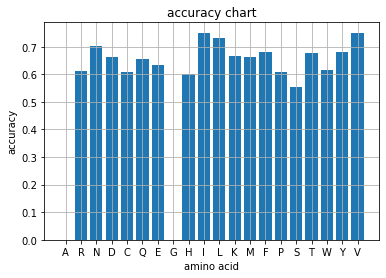

In [22]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
width = 0.8
ax.bar(amino_list[:20], acc_list, width, label='Accuracy')

ax.set(xlabel="amino acid", ylabel='accuracy',
       title='accuracy chart')
ax.grid()

plt.show()

In [23]:
fig.savefig("/mnt/c/Users/HP/Downloads/RES26_acc_individual.png")

In [25]:
with open("/home/chingyuenliu/test/Chi1_native.pkl",'rb') as fp:
    native = pickle.load(fp)

In [26]:
native

{'VAL': [0.0901408890693824, 0.7253044960239362, 0.18455461490668137],
 'LEU': [0.020058869851352967, 0.32975530492558447, 0.6501858252230626],
 'PRO': [0.5071417625757123, 6.989867380708504e-05, 0.49278833875048056],
 'ASN': [0.13957188355557879, 0.30000377425320596, 0.5604243421912153],
 'THR': [0.46863295880149813, 0.09648512781353405, 0.43488191338496784],
 'GLU': [0.09701467236735539, 0.33574105814325805, 0.5672442694893866],
 'ASP': [0.16215662637749495, 0.3278272650657677, 0.5100161085567373],
 'PHE': [0.11079905615169511, 0.3480016013878695, 0.5411993424604354],
 'LYS': [0.08121071602447805, 0.3439677060887297, 0.5748215778867923],
 'ILE': [0.13326116488368145, 0.09880709797928341, 0.7679317371370351],
 'SER': [0.45021585761774097, 0.2527505756543663, 0.2970335667278927],
 'ARG': [0.09659794880924599, 0.3466839563971602, 0.5567180947935938],
 'TYR': [0.1153218590452129, 0.3547344597084057, 0.5299436812463814],
 'GLN': [0.0841549058005267, 0.31565264366263757, 0.6001924505368357

In [28]:
native_max = []

for i in new_amino_list:
    if i not in native:
        native_max.append(0)
        continue
    native_max.append(max(native[i]))

In [30]:
len(native_max)

20

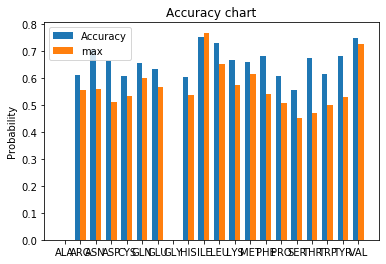

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = new_amino_list
men_means = acc_list
women_means = native_max

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Accuracy')
rects2 = ax.bar(x + width/2, women_means, width, label='max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability')
ax.set_title('Accuracy chart')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


plt.show()

In [35]:
fig.savefig("/mnt/c/Users/HP/Downloads/RES26_accmax_individual.png")